In [1]:
import torch
import numpy as np


def get_randmask(observed_mask, sample_ratio):
        rand_for_mask = torch.rand_like(observed_mask) * observed_mask
        rand_for_mask = rand_for_mask.reshape(len(rand_for_mask), -1)
        for i in range(len(observed_mask)):
            sample_ratio = sample_ratio
            num_observed = observed_mask[i].sum().item()
            num_masked = round(num_observed * sample_ratio)
            rand_for_mask[i][rand_for_mask[i].topk(num_masked).indices] = -1
        cond_mask = (rand_for_mask > 0).reshape(observed_mask.shape).float()
        return cond_mask

In [2]:
import argparse
parser = argparse.ArgumentParser(description='Imputation')

# args for area and methods
parser.add_argument('--area', type=str, default='Chesapeake', help='which bay area we focus')

# basic args
parser.add_argument('--epochs', type=int, default=500, help='epochs')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--wd', type=float, default=1e-4, help='weight decay')
parser.add_argument('--test_freq', type=int, default=500, help='test per n epochs')
parser.add_argument('--embedding_size', type=int, default=32)
parser.add_argument('--hidden_channels', type=int, default=32)
parser.add_argument('--diffusion_embedding_size', type=int, default=64)
parser.add_argument('--side_channels', type=int, default=1)

# args for tasks
parser.add_argument('--in_len', type=int, default=46)
parser.add_argument('--out_len', type=int, default=46)
parser.add_argument('--missing_ratio', type=float, default=0.1)

# args for diffusion
parser.add_argument('--beta_start', type=float, default=0.0001, help='beta start from this')
parser.add_argument('--beta_end', type=float, default=0.2, help='beta end to this')
parser.add_argument('--num_steps', type=float, default=50, help='denoising steps')
parser.add_argument('--num_samples', type=int, default=10, help='n datasets')
parser.add_argument('--schedule', type=str, default='quad', help='noise schedule type')
parser.add_argument('--target_strategy', type=str, default='random', help='mask')

# args for mae
parser.add_argument('--num_heads', type=int, default=8, help='n heads for self attention')
config = parser.parse_args(args=[])

In [13]:
import os
import sys

sys.path.insert(0, "/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/")
print(sys.path)
from dataset.dataset_imputation import PRE8dDataset
from torch.utils.data import DataLoader

test_dloader = DataLoader(PRE8dDataset(config, mode='test'), 1, shuffle=False)

['/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/', '/home/mafzhang/miniconda3/envs/torch/lib/python39.zip', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/mafzhang/.local/lib/python3.9/site-packages', '/home/mafzhang/miniconda3/envs/torch/lib/python3.9/site-packages']


In [14]:
config.method = "GraphDiffusion"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

train_dataset = PRE8dDataset(config)
low_bound = torch.from_numpy(train_dataset.min).float().to(device)
high_bound = torch.from_numpy(train_dataset.max).float().to(device)
adj = np.load("/home/mafzhang/data/{}/8d/adj.npy".format(config.area))
adj = torch.from_numpy(adj).to(device)

model = torch.load("/home/mafzhang/code/CHLA-Imputation-and-Prediction-for-Bay/log/imputation/Chesapeake/{}/best_0.1.pt".format(config.method))
for test_step, (datas, data_ob_masks, data_gt_masks, labels, label_masks) in enumerate(test_dloader):
    datas, data_ob_masks, data_gt_masks, labels, label_masks = datas.float().to(device), data_ob_masks.to(device), data_gt_masks.to(device), labels.to(device), label_masks.to(device)
    data_gt_masks = get_randmask(data_ob_masks, 0.5)
    data_gt_masks = data_gt_masks.to(device)
    imputed_data = model.impute(datas, data_gt_masks, adj, config.num_samples)
    imputed_data = imputed_data.median(dim=1).values
    break

imputed_data = data_gt_masks.cpu()*datas.cpu() + (1-data_gt_masks.cpu())*imputed_data

In [15]:
imputed_data.shape

torch.Size([1, 46, 1, 120])

In [17]:
lon = np.load("/home/mafzhang/data/Chesapeake/8d/lon.npy")
lati = np.load("/home/mafzhang/data/Chesapeake/8d/lati.npy")

In [18]:
is_sea = np.load("/home/mafzhang/data/Chesapeake/8d/is_sea.npy")

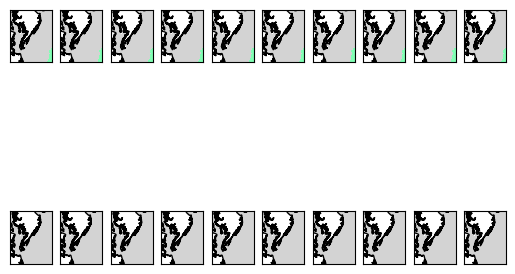

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits import basemap
import numpy as np
import copy
fig, axes = plt.subplots(2, 10)
for i in range(10):
    lon1, lon2, lati1, lati2 = lon.min(), lon.max(), lati.min(), lati.max()
    map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='h', ax=axes[0,i])
    map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
    map.drawcoastlines()
    tmp1 = np.zeros((60,48))
    tmp1[is_sea.astype(bool)]=imputed_data[0,i,0]
    tmp1[~is_sea.astype(bool)]=np.nan
    map.contourf(lon, lati, tmp1, levels=np.linspace(-1.5, 1.5, 10),cmap="rainbow")

    map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='h', ax=axes[1,i])
    map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
    map.drawcoastlines()
    tmp2 = np.zeros((60,48))
    tmp2[~is_sea.astype(bool)]=np.nan
    tmp3 = copy.deepcopy(datas[0,i,0])
    tmp3[~data_ob_masks[0,i,0].bool()]=np.nan
    tmp2[is_sea.astype(bool)]=tmp3.cpu()
    map.contourf(lon, lati, tmp2, levels=np.linspace(-1.5, 1.5, 10),cmap="rainbow")

In [37]:
print(data_ob_masks[0,30,0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


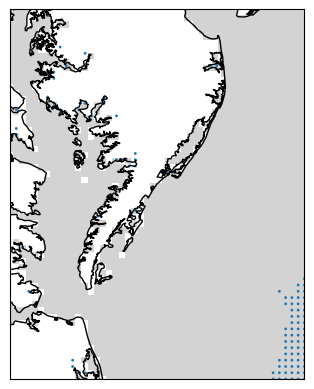

In [42]:
map = basemap.Basemap(llcrnrlon=lon1, llcrnrlat=lati1,urcrnrlon=lon2, urcrnrlat=lati2, projection='cyl', resolution='h')
map.drawlsmask(land_color='white', ocean_color='lightgray', resolution='f',grid=1.25)
map.drawcoastlines()
tmp = np.ones((60,48))
tmp[~is_sea.astype(bool)]=np.nan
map.scatter(lon, lati, tmp, cmap="rainbow")
plt.show()